<font size="6">**Time Series Analysis**</font>

In [1]:

import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import (acf, pacf)
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima

from sklearn.model_selection import (TimeSeriesSplit, cross_validate)
from sklearn.linear_model import LinearRegression

C:\Users\manua\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\manua\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

running notebook configuration


In [4]:
from src.load_data import market_data
from src.mle import time_series as mle_ts
from src import utils

# Parameters

In [5]:
cfg_brent =  utils.conf['fparams']['brent_model']

In [6]:
TAU_TARGET = int(cfg_brent['target_tau'])
KFOLDS = int(cfg_brent['kfolds'])
SPLIT_DT = cfg_brent['split_dt']
DATA_END = cfg_brent['data_dt']

# Load Data

In [7]:
comm_df = market_data.read_mkt_data().loc[:DATA_END, ['brent']]
comm_df['brent_t1'] = comm_df['brent'].shift(-1).iloc[:-1]
comm_df.index.freq = 'B'

target = mle_ts.get_targets(
        y=comm_df.loc[:DATA_END, ['brent']], tau=TAU_TARGET
    ).rename(columns={'brent':'target'})

comm_df = comm_df.join(target, how='inner')

# Split Data

In [8]:
endog_train = comm_df.loc[:SPLIT_DT, 'brent_t1']
endog_test = comm_df.loc['2020':, 'brent_t1']

In [9]:
X_train = comm_df.loc[:SPLIT_DT, ['brent']]
y_train = target.loc[:SPLIT_DT, 'target']

X_test = comm_df.loc[:SPLIT_DT, ['brent']]
y_test = target.loc['2020':, 'target']

# Time Series Analysis

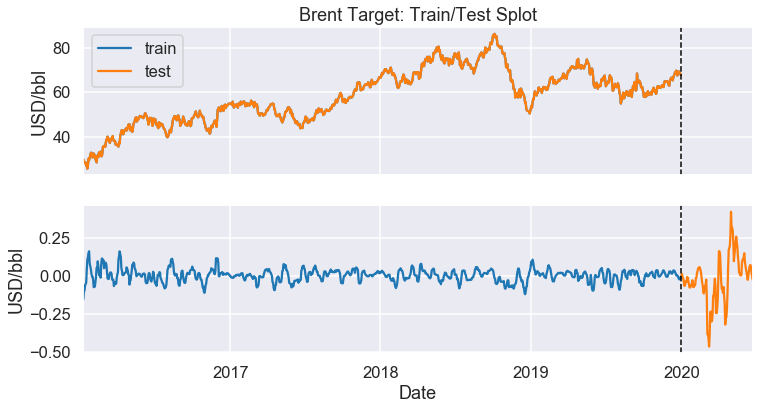

In [10]:
fig, axs = plt.subplots(2,1, sharex=True)

ax = axs[0]
X_train.plot(ax=ax, label='train')
X_test.plot(ax=ax, label='test')
ax.set_title('Brent Target: Train/Test Splot')
ax.legend(labels=['train', 'test'])

ax = axs[1]
y_train.plot(ax=ax)
y_test.plot(ax=ax)

for ax in axs:
    ax.set_ylabel('USD/bbl')
    ax.axvline(x=SPLIT_DT, color='black', linestyle='--', linewidth=1.5)
    
plt.show()

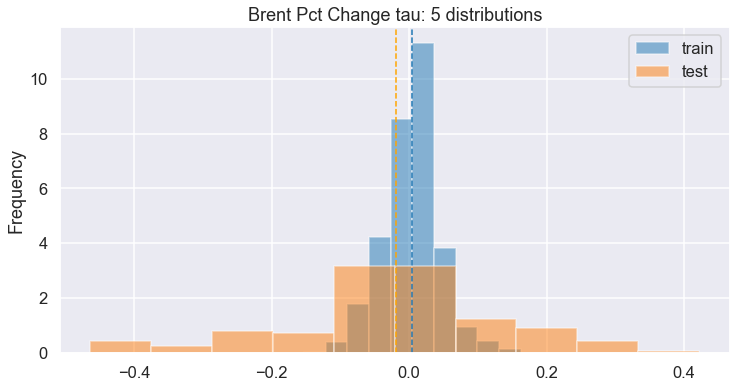

In [11]:
ax = y_train.plot.hist(density=True, alpha=0.5, label='train')
ax.axvline(x=y_train.mean(),  linestyle='--', linewidth=1.5)
y_test.plot.hist(ax=ax, density=True, alpha=0.5, label='test')
ax.axvline(x=y_test.mean(),  linestyle='--', linewidth=1.5, color='orange')
plt.legend()
plt.title(f'Brent Pct Change tau: {TAU_TARGET} distributions')
plt.show()

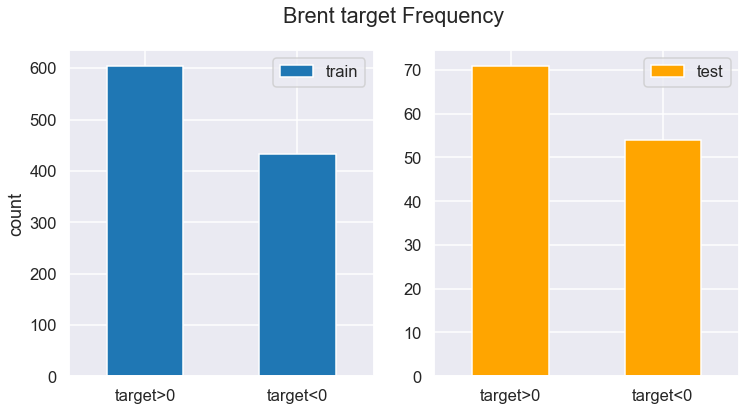

In [12]:
fig, axs = plt.subplots(1, 2)

plt.suptitle(f'Brent target Frequency')
ax = axs[0]
(y_train>0).value_counts().astype(int).plot.bar(ax=ax, label='train')
ax.set_ylabel('count')

ax = axs[1]
(y_test>0).value_counts().astype(int).plot.bar(ax=ax, color='orange', label='test')

for ax in axs:
    ax.legend()
    ax.set_xticklabels(['target>0', 'target<0'], rotation=0)

plt.show()

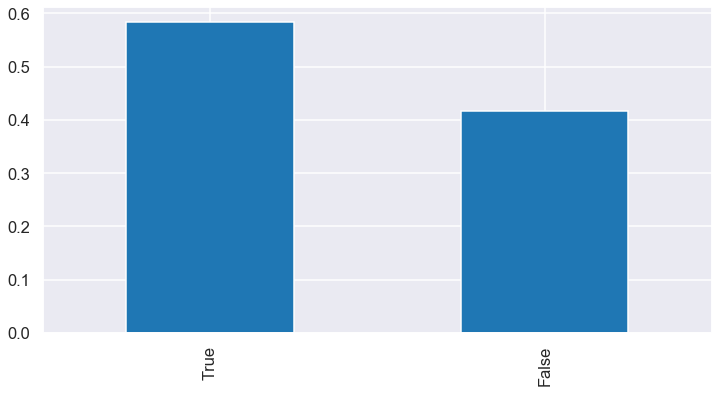

In [13]:
#naive forecast
(y_train>0).value_counts(normalize=True).plot.bar()
plt.show()


In [14]:
(y_train>0).mean()

0.583413693346191

## ACF and PACF

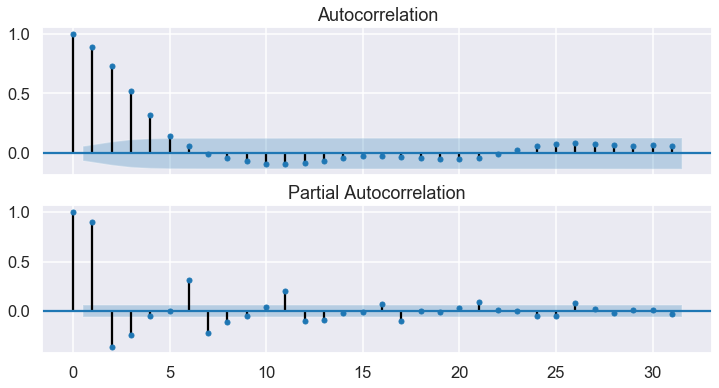

In [15]:
fig , axs = plt.subplots(2,1, sharex=True)

ax = axs[0]
plot_acf(y_train, ax=ax)

ax = axs[1]
plot_pacf(y_train, ax=ax)
plt.show()

## Stationarity

In [16]:
mle_ts.adfuller(y_train)

(-6.000641831656124,
 1.6605779352241803e-07,
 22,
 1014,
 {'1%': -3.4368154156758943,
  '5%': -2.864394550773568,
  '10%': -2.5682898917327046},
 -6064.036323224089)

In [17]:
mle_ts.adfuller(y_test)

(-2.0391216980140077,
 0.2696872880923654,
 12,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 -352.93943593943504)

In [18]:
mle_ts.adfuller(target)

(-5.092938034891424,
 1.4484690404390254e-05,
 21,
 1140,
 {'1%': -3.4360991979671205,
  '5%': -2.864078635828568,
  '10%': -2.568121635118498},
 -5892.927238367094)

Time series is stationary on first differences, it seems that order 1 AR or MA model may fit. In addition, a small seasonal component may be present at lag 5-6 (although not very regular)

## Sesonality

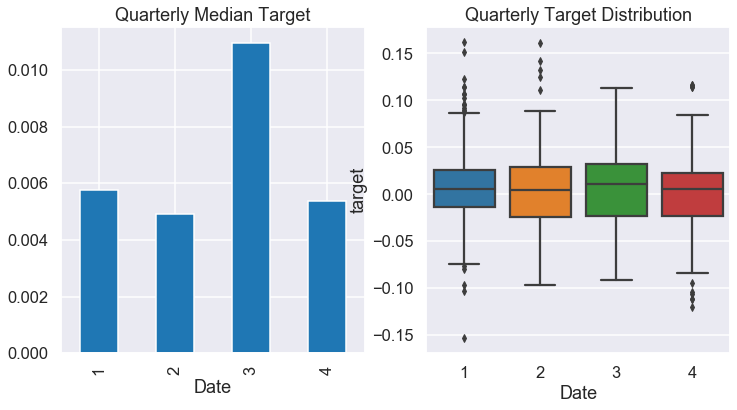

In [19]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
y_train.groupby(y_train.index.quarter).median().plot.bar(ax=ax)
ax.set_title('Quarterly Median Target')
ax = axs[1]
sns.boxplot(y=y_train, x=y_train.index.quarter, ax=ax)
ax.set_title('Quarterly Target Distribution')
plt.show()

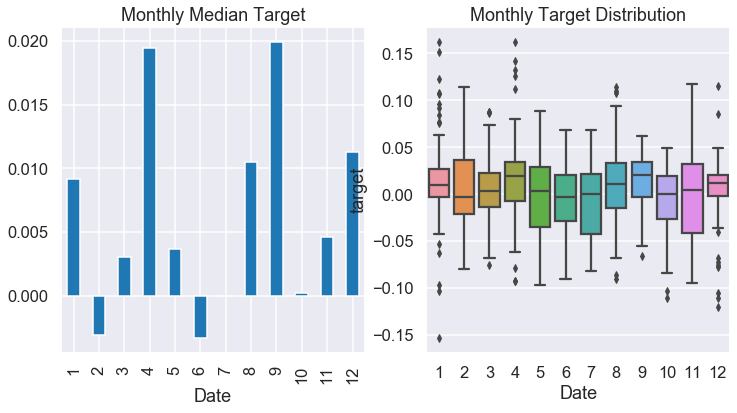

In [20]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
y_train.groupby(y_train.index.month).median().plot.bar(ax=ax)
ax.set_title('Monthly Median Target')
ax = axs[1]
sns.boxplot(y=y_train, x=y_train.index.month, ax=ax)
ax.set_title('Monthly Target Distribution')
plt.show()

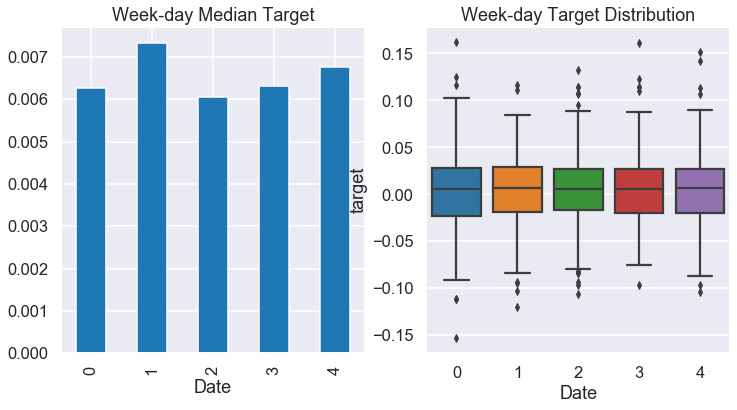

In [21]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
y_train.groupby(y_train.index.weekday).median().plot.bar(ax=ax)
ax.set_title('Week-day Median Target')
ax = axs[1]
sns.boxplot(y=y_train, x=y_train.index.weekday, ax=ax)
ax.set_title('Week-day Target Distribution')
plt.show()

Seasonal pattern is not noticable at a visual level

# Model Building

In [22]:
# Fit your model
model = auto_arima(endog_train, seasonal=False, start_p=0, start_q=0, d=1, max_p=7, max_q=7, with_intercept=False, trace=True, max_order=15, n_fits=20, stepwise=True)

C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(0, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0); AIC=3246.956, BIC=3256.843, Fit time=0.000 seconds
Fit ARIMA: order=(0, 1, 1); AIC=3246.925, BIC=3256.811, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 1); AIC=3248.367, BIC=3263.197, Fit time=0.070 seconds
Fit ARIMA: order=(0, 1, 2); AIC=3247.533, BIC=3262.362, Fit time=0.029 seconds
Fit ARIMA: order=(1, 1, 2); AIC=3249.532, BIC=3269.305, Fit time=0.130 seconds
Total fit time: 0.255 seconds


In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1036
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1621.462
Method:                       css-mle   S.D. of innovations              1.157
Date:                Sun, 18 Apr 2021   AIC                           3246.925
Time:                        19:21:42   BIC                           3256.811
Sample:                             1   HQIC                          3250.676
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y     -0.0208      0.032     -0.645      0.519      -0.084       0.042
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           48.0408           +0.0000j           48.0408            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
# Fit your model
model_seas = auto_arima(endog_train, seasonal=True, m=5, start_p=0, start_q=0, d=1, max_p=7, max_q=7, with_intercept=False, trace=True, max_order=15, n_fits=20, stepwise=True, information_criterion='aic')

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 5); AIC=3249.338, BIC=3264.167, Fit time=0.097 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=3245.340, BIC=3250.283, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 5); AIC=3248.252, BIC=3263.081, Fit time=0.082 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 5); AIC=3248.152, BIC=3262.981, Fit time=0.095 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 5); AIC=3246.592, BIC=3256.478, Fit time=0.049 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 5); AIC=3246.516, BIC=3256.402, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=3246.956, BIC=3256.843, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 5); AIC=3246.925, BIC=3256.811, Fit time=0.043 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 5); AIC=3248.367, BIC=3263.197, Fit time=0.132 seconds
Total fit time: 0.625 seconds


In [25]:
model_seas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1037
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1621.670
Date:                Sun, 18 Apr 2021   AIC                           3245.340
Time:                        19:21:43   BIC                           3250.283
Sample:                             0   HQIC                          3247.216
                               - 1037                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.3401      0.041     32.770      0.000       1.260       1.420
===================================================================================
Ljung-Box (Q):                       38.61   Jarque-Bera (JB):               198.85
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
sarimax_seas = SARIMAX(endog_train, order=(0,1,0), seasonal_order=(0,0,0,5))
sarimax_seas_res = sarimax_seas.fit()

In [27]:
sarimax_seas_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               brent_t1   No. Observations:                 1037
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1621.670
Date:                Sun, 18 Apr 2021   AIC                           3245.340
Time:                        19:21:43   BIC                           3250.283
Sample:                    01-11-2016   HQIC                          3247.216
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.3401      0.041     32.770      0.000       1.260       1.420
===================================================================================
Ljung-Box (Q):                       38.61   Jarque-Bera (JB):               198.85
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A seasonal model does not seem to improve a non seasonal one

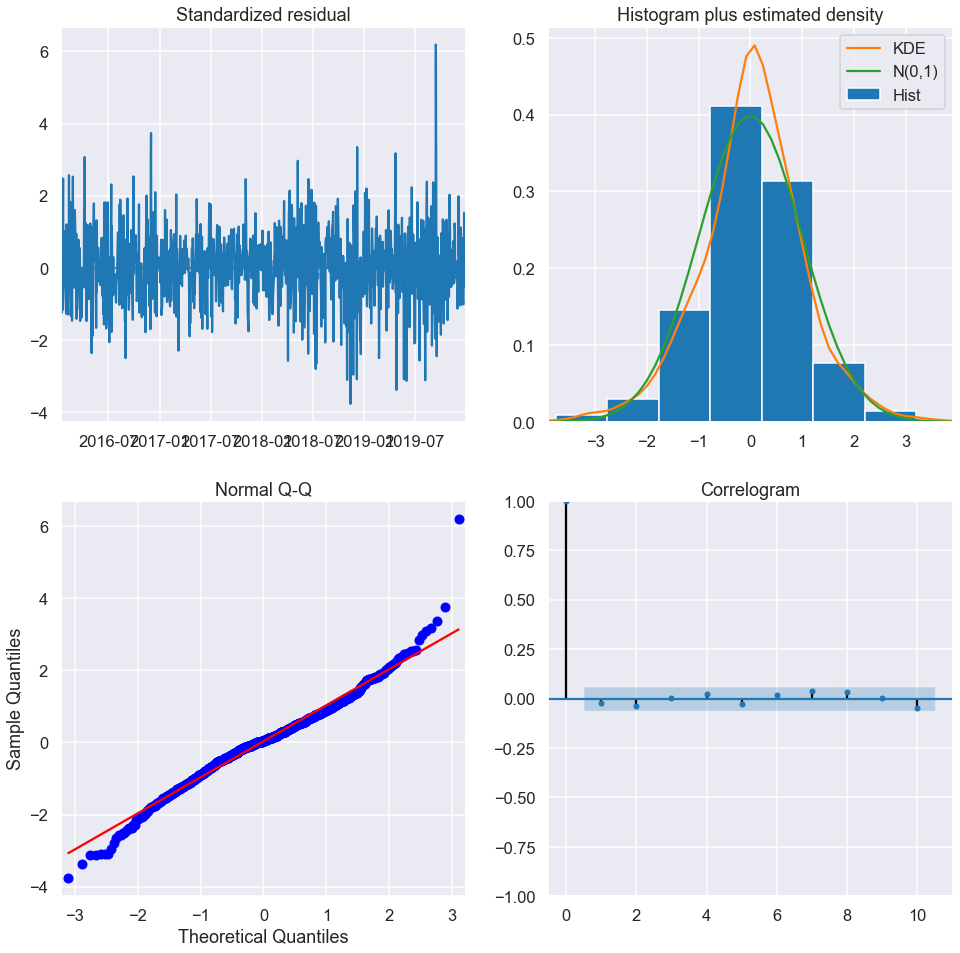

In [28]:
sarimax_seas_res.plot_diagnostics(figsize=(16,16))
plt.show()

In [29]:
p_train = sarimax_seas_res.predict()
pd.concat([p_train.head(3), p_train.tail(3)], axis=0)

Date
2016-01-11    0.0000
2016-01-12   29.1400
2016-01-13   28.5800
2019-12-27   68.9100
2019-12-30   68.3000
2019-12-31   67.7700
dtype: float64

# Model Evaluation

In [30]:
pd.crosstab(p_train.diff()>0, endog_train.diff()>0, normalize=True)

brent_t1,False,True
row_0,,
False,0.2411,0.2420
True,0.2430,0.2739


In train set, directional accuracy is above 60%, higher than naive forecast at 58%. As a benchark model, a simple ARIMA is a good candidate